In [1]:
from dataclasses import dataclass, field
from typing import Dict, Literal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

In [2]:
@dataclass
class InputParameters:
    T: float # temperature [K]
    p0: float # CO2 partial pressure [atm]
    Q: float # Flow rate [mL/min]
    flow_chan_length: float # Flow channel active length [m]
    flow_chan_height: float # Flow channel height (plane parallel) [m]
    flow_chan_width: float # Flow channel width (plane perpendicular) [m]
    L: float # Catalyst layer length [m]
    eps: float # Catalyst layer porosity
    r : float # Catalyst layer average particle radius [m]
    c_khco3: float # KHCO3 concentration [mol/m^3]
    c_k: float # K+ concentration [mol/m^3]
    dic: float # ?
    method: str # Method for calculating CO2 concentration (DIC or CO2 eql)

    @property
    def v(self): # flow velocity [m/s]
        return self.Q / (self.flow_chan_height * self.flow_chan_width) * 1e-6 / 60
    
    @property
    def volumetric_surface_area(self):
        return 3 * (1 - self.eps) / self.r # m^-1
    
class System:
    diffusion_coefficients: Dict[str, float]
    salting_out_exponents: Dict[str, float]
    electrode_reaction_kinetics: Dict[str, float]
    chemical_reaction_rates: Dict[str, float]

    T: float # temperature [K]
    R: float = 8.3145 # Universal gas constant [J/(mol*K)]
    F: float = 96485 # Faraday constant [C/mol]
    
    @property
    def T(self) -> float:
        return self.input_parameters.T

    @property
    def Hnr(self) -> float:
        T = self.T
        return 1000*np.exp(93.4517*100/T - 60.2409 + 23.3585*np.log(T/100)) # Henry's constant for CO2 [mol/(L*atm)]
    
    def __init__(self, input_parameters: InputParameters):
        self.diffusion_coefficients = {
            'CO2': 1.91e-09,
            'OH': 5.293e-09,
            'CO3': 9.23e-10,
            'HCO3': 1.18e-09,
            'H': 9.311e-09,
            'K': 1.96e-09,
            'CO': 2.03e-09,
            'H2': 4.5e-09
        } # [m^2/s]

        self.salting_out_exponents = {
            'h_OH': 6.67e-05,
            'h_CO3': 0.0001251,
            'h_HCO3': 7.95e-05,
            'h_K': 7.5e-05,
            'h_CO2': 0.0
        } # [m^3/mol]

        self.electrode_reaction_kinetics = {
            'i_0_CO': 0.00471, # [A/m^2]
            'i_0_H2a': 0.00979, # [A/m^2]
            'i_0_H2b': 1.16e-05, # [A/m^2] not used in the calculation
            'alpha_CO': 0.44,
            'alpha_H2a': 0.27,
            'alpha_H2b': 0.36,
            'E_0_CO2': -0.11, # [V]
            'E_0_H2a': 0.0, # [V]
            'E_0_H2b': 0.0 # [V]
        }

        self.chemical_reaction_rates = {
            'k1f': 2.23, # [m^3/(mol s)]
            # 'k1r': 0.000840308, # [1/s]
            # 'k2f': 6000000.0, # [m^3/(mol s)]
            # 'k2r': 345200.0, # [1/s]
            'c_ref': 1000.0 # [mol/m^3]
        }

        self.input_parameters = input_parameters
        self.update_diffusion_coefficients()
        self.set_butler_volmer_coefficients()
        self.set_flow_channel_characteristics()
        self.set_initial_carbonate_equilibria()

    def update_diffusion_coefficients(self):
        substances = list(self.diffusion_coefficients.keys())
        for substance in substances:
            self.diffusion_coefficients[f'D{substance}'] = self.diffusion_coefficients[substance]*self.input_parameters.eps**1.5 # Bruggeman correction for diffusion coefficient [m^2/s]
        self.diffusion_coefficients['Gas diffusion layer mass transfer coefficient'] = self.diffusion_coefficients['DCO2'] / self.input_parameters.r # [m/s]

    def set_butler_volmer_coefficients(self):
        alpha_to_b = lambda alpha: self.T*self.R/(alpha*self.F)
        self.electrode_reaction_kinetics['b_CO2'] = alpha_to_b(self.electrode_reaction_kinetics['alpha_CO'])
        self.electrode_reaction_kinetics['b_H2a'] = alpha_to_b(self.electrode_reaction_kinetics['alpha_H2a'])
        self.electrode_reaction_kinetics['b_H2b'] = alpha_to_b(self.electrode_reaction_kinetics['alpha_H2b'])
    
    def set_flow_channel_characteristics(self):
        input_parameters = self.input_parameters
        flow_channel_characteristics = {
            'mu': 0.00000093944, # [m^2/s]
        }
        flow_channel_characteristics['Reynolds Number'] = input_parameters.v*input_parameters.flow_chan_length/flow_channel_characteristics['mu']
        flow_channel_characteristics['Hydrodynamic Entrance length'] = 0.0099*flow_channel_characteristics['Reynolds Number']*input_parameters.flow_chan_width
        flow_channel_characteristics['Parallel plate effective boundary layer'] = 13/35*input_parameters.flow_chan_width
        diff_coeff_to_bl_thickness = lambda x: 3*1.607/4*(input_parameters.flow_chan_width*x*input_parameters.flow_chan_length/input_parameters.v)**(1/3)
        diff_coeff_to_K_L = lambda D,L: D*np.sqrt(L**-2+flow_channel_characteristics['Parallel plate effective boundary layer']**-2)/np.sqrt(2)
        for substance in ['CO2', 'OH', 'CO3', 'HCO3', 'H', 'K', 'CO', 'H2']:
            flow_channel_characteristics[f'Developing boundary layer thickness {substance} (average)'] = diff_coeff_to_bl_thickness(self.diffusion_coefficients[substance])
        for substance in ['CO2', 'OH', 'CO3', 'HCO3', 'H', 'K', 'CO', 'H2']:
            flow_channel_characteristics[f'K_L_{substance}'] = diff_coeff_to_K_L(self.diffusion_coefficients[substance], flow_channel_characteristics[f'Developing boundary layer thickness {substance} (average)'])

        self.flow_channel_characteristics = flow_channel_characteristics

    def set_initial_carbonate_equilibria(self):
        T = self.T
        kco3_to_salinity = lambda x: x/(1.005*x/1000+19.924)
        initial_carbonate_equilibria = {
            'Salinity': kco3_to_salinity(self.input_parameters.c_khco3),
            'pK1_0': -126.34048 + 6320.813/T + 19.568224*np.log(T),
            'pK2_0': -90.18333 + 5143.692/T + 14.613358*np.log(T),
        }
        salinity_to_A1 = lambda x: 13.4191*x**0.5 + 0.0331*x - 5.33e-5*x**2
        initial_carbonate_equilibria['A1'] = salinity_to_A1(initial_carbonate_equilibria['Salinity'])
        salinity_to_A2 = lambda x: 21.0894*x**0.5 + 0.1248*x - 3.687e-4*x**2
        initial_carbonate_equilibria['A2'] = salinity_to_A2(initial_carbonate_equilibria['Salinity'])
        salinity_to_B1 = lambda x: -530.123*x**0.5 - 6.103*x
        initial_carbonate_equilibria['B1'] = salinity_to_B1(initial_carbonate_equilibria['Salinity'])
        salinity_to_B2 = lambda x: -772.483*x**0.5 - 20.051*x
        initial_carbonate_equilibria['B2'] = salinity_to_B2(initial_carbonate_equilibria['Salinity'])
        initial_carbonate_equilibria['C1'] = -2.0695*initial_carbonate_equilibria['Salinity']**0.5
        initial_carbonate_equilibria['C2'] = -3.3336*initial_carbonate_equilibria['Salinity']**0.5
        initial_carbonate_equilibria['pK1'] = initial_carbonate_equilibria['pK1_0'] + initial_carbonate_equilibria['A1'] + initial_carbonate_equilibria['B1']/T + initial_carbonate_equilibria['C1']*np.log(T)
        initial_carbonate_equilibria['pK2'] = initial_carbonate_equilibria['pK2_0'] + initial_carbonate_equilibria['A2'] + initial_carbonate_equilibria['B2']/T + initial_carbonate_equilibria['C2']*np.log(T)
        initial_carbonate_equilibria['K1'] = 10**-initial_carbonate_equilibria['pK1']
        initial_carbonate_equilibria['K2'] = 10**-initial_carbonate_equilibria['pK2']
        initial_carbonate_equilibria['Kw'] = np.exp(148.96502 - 13847.26/T - 23.6521*np.log(T) + (-5.977 + 118.67/T + 1.0495*np.log(T))*initial_carbonate_equilibria['Salinity']**0.5 - 0.01615*initial_carbonate_equilibria['Salinity'])

        self.initial_carbonate_equilibria = initial_carbonate_equilibria

    def calculate_co2_equilibrium(self):
        ice = self.initial_carbonate_equilibria
        input_parameters = self.input_parameters

        co2_init = self.Hnr*input_parameters.dic
        a = 1
        b = input_parameters.c_khco3/1000
        c = lambda co2: -(ice['Kw'] + ice['K1']*co2/1000)
        d = lambda co2: -2*co2/1000*ice['K1']*ice['K2']
        f_xn = lambda x, a,b,c,d: a*x**3 + b*x**2 + c*x + d
        df_xn = lambda x, a,b,c,d: 3*a*x**2 + 2*b*x + c 
        xn_to_co2 = lambda xn, co2: self.Hnr*input_parameters.dic*np.exp(
            -input_parameters.c_k*self.salting_out_exponents['h_K'] -
            self.salting_out_exponents['h_HCO3']*co2*ice['K1']/xn -
            co2*self.salting_out_exponents['h_CO3']*ice['K1']*ice['K2']/xn**2 -
            self.salting_out_exponents['h_OH']*ice['Kw']/xn*1000
        )
        # find root of f(x) = 0
        co2 = co2_init
        for i in range(3):
            x_n = opt.newton(f_xn, x0=1e-5, fprime=df_xn, tol=1e-36, args=(a,b,c(co2),d(co2)))
            co2 = xn_to_co2(x_n, co2)

        co2_equilibrium_sol = {
            'final_pH': -np.log10(x_n),
            'CO2': co2,
            'HCO3': co2*ice['K1']/x_n,
            'OH': ice['Kw']/x_n * 1000,
            'K': input_parameters.c_k,
        }
        co2_equilibrium_sol['CO3'] = co2_equilibrium_sol['HCO3']*ice['K2']/x_n
        co2_equilibrium_sol
        return co2_equilibrium_sol

    def calculate_dic_solution(self):
        ice = self.initial_carbonate_equilibria
        dic_electrolyte_solution = {
            'initial_pH': 7,
        }
        a = 1
        b = ice['K1'] + self.input_parameters.c_khco3/1000
        c = ice['K1']*ice['K2'] - ice['Kw']
        d = -ice['K1']*(ice['Kw'] + ice['K2']*self.input_parameters.c_khco3/1000)
        e = -ice['Kw']*ice['K2']*ice['K1']
        x_n = 1e-4
        f_xn = lambda x: a*x**4 + b*x**3 + c*x**2 + d*x + e
        df_xn = lambda x: 4*a*x**3 + 3*b*x**2 + 2*c*x + d
        # find root of f(x) = 0
        x_n = opt.newton(f_xn, x_n, fprime=df_xn, tol=1e-35)
        dic_electrolyte_solution['final_pH'] = -np.log10(x_n)
        dic_electrolyte_solution['CO2'] = self.input_parameters.c_khco3/(1 + ice['K1']/x_n + ice['K1']*ice['K2']/x_n**2)
        dic_electrolyte_solution['HCO3'] = dic_electrolyte_solution['CO2']*ice['K1']/x_n
        dic_electrolyte_solution['CO3'] = dic_electrolyte_solution['HCO3']*ice['K2']/x_n
        dic_electrolyte_solution['OH'] = ice['Kw']/x_n * 1000
        dic_electrolyte_solution['K'] = self.input_parameters.c_khco3
        dic_electrolyte_solution
        return dic_electrolyte_solution

In [3]:
def solve(S: System, phi_ext: np.ndarray):
    A = S.input_parameters.volumetric_surface_area
    F = S.F
    R = S.R
    T = S.T
    L = S.input_parameters.L
    Hnr = S.Hnr
    Hnr_c = lambda c1, c2: Hnr*np.exp(-S.salting_out_exponents['h_OH']*c1 - S.salting_out_exponents['h_CO3']*c2 - S.salting_out_exponents['h_K']*(c1+2*c2))
    E_CO = S.electrode_reaction_kinetics['E_0_CO2']
    if S.input_parameters.method=='DIC':
        dic_electrolyte_solution = S.calculate_dic_solution()
        OH_neg = dic_electrolyte_solution['OH']
        HCO3_neg = dic_electrolyte_solution['HCO3']
        CO3_2neg = dic_electrolyte_solution['CO3']
    elif S.input_parameters.method=='CO2 eql':
        co2_equilibrium_sol = S.calculate_co2_equilibrium()
        OH_neg = co2_equilibrium_sol['OH']
        HCO3_neg = co2_equilibrium_sol['HCO3']
        CO3_2neg = co2_equilibrium_sol['CO3']

    overpotential = phi_ext - E_CO
    M = lambda k: np.sqrt(k*L**2/S.diffusion_coefficients['DCO2'])

    # solve without equilibrium reactions
    k0 = A/(2*F) * S.electrode_reaction_kinetics['i_0_CO']/S.chemical_reaction_rates['c_ref'] * np.exp(
        -overpotential/(S.electrode_reaction_kinetics['b_CO2']))
    eff_0 = 1/(M(k0)/np.tanh(M(k0)) + k0*L/S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient'])
    c00 = Hnr*S.input_parameters.p0*eff_0

    # estimating OH- concentration
    r_H2 = A*S.electrode_reaction_kinetics['i_0_H2b']/F * np.exp(-phi_ext/S.electrode_reaction_kinetics['b_H2b']) # phi_ext is with respect to SHE
    c10 = OH_neg+(
        S.flow_channel_characteristics['K_L_OH']*OH_neg - 
        1/(
            1/(L*(r_H2+2*k0*c00)) +
            1/(S.flow_channel_characteristics['K_L_HCO3']*HCO3_neg)
        )
        + L*(r_H2+2*k0*c00)
    ) / (
        S.flow_channel_characteristics['K_L_OH'] + 2*S.input_parameters.eps*L*S.chemical_reaction_rates['k1f']*c00
    )

    # update CO2 concentration 
    k1 = k0 + S.input_parameters.eps*S.chemical_reaction_rates['k1f']*c10
    eff_1 = 1/(M(k1)/np.tanh(M(k1)) + k1*L/S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient'])
    c01 = eff_1*S.input_parameters.p0*Hnr
    # update OH- concentration
    c11 = OH_neg + (
        S.flow_channel_characteristics['K_L_OH']*OH_neg - 1/(
            1/(L*(r_H2+2*k0*c01)) + 1/(S.flow_channel_characteristics['K_L_HCO3']*HCO3_neg)
        ) + L*(r_H2+2*k0*c01) 
        ) / (
        S.flow_channel_characteristics['K_L_OH']+2*S.chemical_reaction_rates['k1f']*L*S.input_parameters.eps*c01
    )
    # solve for CO3--
    A_1 = (
        2*S.flow_channel_characteristics['K_L_CO3']*CO3_2neg + S.flow_channel_characteristics['K_L_HCO3']*HCO3_neg + S.flow_channel_characteristics['K_L_OH']*OH_neg + L*r_H2 - S.flow_channel_characteristics['K_L_OH']*c11
    ) / (2*S.flow_channel_characteristics['K_L_CO3'])
    B_2 = L*2*k0*c01 / (2*S.flow_channel_characteristics['K_L_CO3']) * np.exp(-c11*(S.salting_out_exponents['h_OH']+S.salting_out_exponents['h_K']))
    C = S.salting_out_exponents['h_CO3']+2*S.salting_out_exponents['h_K']
    c20 = A_1+np.log(
        1+(B_2*C * np.exp(-A_1*C)) / (1+np.log(np.sqrt(1+B_2*C*np.exp(-A_1*C))))
        ) / C
    # salting out corrected CO2 concentration
    c02 = eff_1*S.input_parameters.p0*Hnr_c(c11,c20)
    # corrected OH- concentration
    c12 = OH_neg + (
        S.flow_channel_characteristics['K_L_OH']*OH_neg - 1/(
            1/(L*(r_H2+2*k0*c02)) + 1/(S.flow_channel_characteristics['K_L_HCO3']*HCO3_neg)
        ) + L*(r_H2+2*k0*c02)
        ) / (
        S.flow_channel_characteristics['K_L_OH']+2*S.chemical_reaction_rates['k1f']*L*S.input_parameters.eps*c02
    )

    k2 = k0 + S.input_parameters.eps*S.chemical_reaction_rates['k1f']*c12
    eff_2 = 1/(
        np.sqrt(
            k2*L**2/S.diffusion_coefficients['DCO2']
        ) / np.tanh(np.sqrt(
            k2*L**2/S.diffusion_coefficients['DCO2']
        )) + k2*L/S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient']
    )
    A_1_1 = (
        2*S.flow_channel_characteristics['K_L_CO3']*CO3_2neg + S.flow_channel_characteristics['K_L_HCO3']*HCO3_neg + S.flow_channel_characteristics['K_L_OH']*OH_neg + L*r_H2 - S.flow_channel_characteristics['K_L_OH']*c12
    ) / (2*S.flow_channel_characteristics['K_L_CO3'])
    # formula for this B2 is different than for the previous B2
    B_2_1 = L*2*k0*eff_2*Hnr*S.input_parameters.p0 / (2*S.flow_channel_characteristics['K_L_CO3']) * np.exp(-c12*(S.salting_out_exponents['h_OH']+S.salting_out_exponents['h_K']))
    c21 = A_1_1+np.log(
        1+(
            B_2_1*(S.salting_out_exponents['h_CO3']+2*S.salting_out_exponents['h_K']) * np.exp(-A_1_1*(S.salting_out_exponents['h_CO3']+2*S.salting_out_exponents['h_K']))
            ) / (
                1+np.log(np.sqrt(1+B_2_1*(S.salting_out_exponents['h_CO3']+2*S.salting_out_exponents['h_K'])*np.exp(-A_1_1*(S.salting_out_exponents['h_CO3']+2*S.salting_out_exponents['h_K']))))
                )
        ) / (
        S.salting_out_exponents['h_CO3']+2*S.salting_out_exponents['h_K']
    )
    c21 = np.maximum(c21, 0)
    c03 = S.input_parameters.p0*Hnr_c(c12, c21)*eff_2
    potential_vs_rhe = phi_ext - R*T/F*np.log(c12/OH_neg)
    co_current_density = L*c03*k0*2*F/10
    co2 = c03
    co3 = c21
    pH = np.log10(c12/1000/S.initial_carbonate_equilibria['Kw'])
    fe = co_current_density*10/(co_current_density*10+(F*L*r_H2))
    current = co_current_density + (F*L*r_H2)/10
    parasitic = c03*c12*S.input_parameters.eps*L*S.chemical_reaction_rates['k1f']
    electrode = L*k0*c03
    gdl_flux = S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient']*(
        Hnr_c(c12,c21)*S.input_parameters.p0 - c03*np.sqrt(
            k2*L**2/S.diffusion_coefficients['DCO2']
        ) / np.tanh(
            np.sqrt(k2*L**2/S.diffusion_coefficients['DCO2'])
        )
    )
    ve_rhe = (S.electrode_reaction_kinetics['E_0_CO2'] - R*T/F*np.log(c12/OH_neg))/potential_vs_rhe
    ve_rhe = np.minimum(ve_rhe, 1)
    hco3 = np.minimum(
        HCO3_neg+Hnr_c(c12,c21)*S.input_parameters.p0,
        co3*10**(3-pH)/S.initial_carbonate_equilibria['K1']
    )
    ee = np.minimum(1, fe*ve_rhe)
    ve_she = (S.electrode_reaction_kinetics['E_0_CO2'] - R*T/F*pH) / (
        phi_ext - R*T/F*pH
    )
    ve_she = np.minimum(1, ve_she)
    ve_agcl = (S.electrode_reaction_kinetics['E_0_CO2'] - R*T/F*pH - 0.2) / (
        phi_ext - R*T/F*pH - 0.2
    )
    ve_agcl = np.minimum(1, ve_agcl)
    eeshe = fe*ve_she
    eeagcl = fe*ve_agcl
    solubility = Hnr_c(c12,c21)/Hnr
    return {
        'phi_ext': phi_ext,
        'k0': k0,
        'eff_0': eff_0,
        'c00': c00,
        'r_H2': r_H2,
        'c10': c10,
        'k1': k1,
        'eff_1': eff_1,
        'c01': c01,
        'c11': c11,
        'A_1': A_1,
        'B_2': B_2,
        'c20': c20,
        'c02': c02,
        'c12': c12,
        'k2': k2,
        'eff_2': eff_2,
        'c03': c03,
        'c21': c21,
        'A_1_1': A_1_1,
        'B_2_1': B_2_1,
        'potential_vs_rhe': potential_vs_rhe,
        'co_current_density': co_current_density,
        'current_density': current,
        'co2': co2,
        'co3': co3,
        'pH': pH,
        'fe': fe,
        'parasitic': parasitic,
        'electrode': electrode,
        'gdl_flux': gdl_flux,
        've_rhe': ve_rhe,
        'hco3': hco3,
        'ee': ee,
        've_she': ve_she,
        've_agcl': ve_agcl,
        'eeshe': eeshe,
        'eeagcl': eeagcl,
        'solubility': solubility
    }

In [4]:
def solve_current(S: System, current: np.ndarray):
    f = lambda phi: (solve(S, phi)['current_density'] - current)**2
    res = opt.minimize_scalar(f, bounds=(-2,0))
    if not res.success:
        print(res.message)
    phi = res.x
    return solve(S, phi)

In [5]:
ipt = InputParameters(T=298.15, p0=1, Q=5, flow_chan_length=0.02, flow_chan_height=5e-3, flow_chan_width=1.5e-3, L=3.81E-06, eps=0.5, r=5e-8, c_khco3=500, c_k=500, dic=10**-3.408, method='DIC')
S = System(ipt)

In [6]:
results = solve(S, np.linspace(0, -1.200, 241))

In [7]:
if ipt.method=='DIC':
    varying_potential = pd.read_excel('./1-s2.0-S0013468621012779-mmc2.xlsx', sheet_name='Varying Potential')
elif ipt.method == 'CO2 eql':
    varying_potential = pd.read_excel('./co2_eql.xlsx', sheet_name='Varying Potential')
else:
    raise ValueError

column_map = {
    'A_1.1': 'A_1_1',
    'B_2.1': 'B_2_1',
    'Potential vs RHE': 'potential_vs_rhe',
    'CO Current Density (mA/cm^2)': 'co_current_density',
    'CO2 (mol/m^3)': 'co2',
    'CO3 (mol/m^3)': 'co3',
    'FE': 'fe',
    'HCO3 (mol/m^3)': 'hco3',
    'VE(RHE)': 've_rhe',
    'EE(%)': 'ee',
    'VE(SHE%)': 've_she',
    'VE(Ag/Cl%)': 've_agcl',
    'EEAg/Cl': 'eeagcl',
}
k = 0
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for col in varying_potential.columns[4:]:
    from_spreadsheet = varying_potential[col].values
    try:
        if col in column_map:
            from_python = results[column_map[col]]
        else:
            col = col.replace(' ', '_')
            from_python = results[col]
        # print(f'{col} is OK')
    except:
        try:
            from_python = results[col[0].lower()+col[1:]]
            # print(f'{col} is OK')
        except:
            try:
                from_python = results[col.lower()]
            except:
                print(f'Error in {col}')
    if not np.allclose(from_spreadsheet, from_python, rtol=1e-2):
        ax[k//4,k%4].scatter(from_spreadsheet, from_python, s=1)
        ax[k//4,k%4].axline([0,0], slope=1, color='k', lw=0.5)
        ax[k//4,k%4].set_title(col)
        print(f'{col} mismatch')
        k += 1
    del from_python, from_spreadsheet
fig.tight_layout()
if k>0:
    plt.show()
else:
    plt.close()

In [8]:
base_args = dict(T=298.15, p0=1, Q=5, flow_chan_length=0.02, flow_chan_height=5e-3, flow_chan_width=1.5e-3, L=3.81E-06, eps=0.5, r=5e-8, c_khco3=500, c_k=500, dic=10**-3.408, method='DIC')

In [9]:
variations = {
    'method': ['DIC', 'CO2 eql'],
    'Q': [1,3,10,30],
    'p0': [0.1,1,10,100],
    'c_khco3': [5,50,500,1000],
    'eps': [0.1,0.5,0.9],
    'r': [5e-9, 5e-8, 5e-7],
    'L': [3.81e-6, 1e-5, 1e-4],
    'flow_chan_width': [1.5e-4, 1.5e-3, 1.5e-2],
}

Probe the effects of parameters:
- method DIC vs CO2 equilibrium: insignificant
- flow rate, Q, largely insignificant
- CO2 partial pressure, p0: very sensitive. Higher p0 is better. (solubility of CO ${}_2$ is an important consideration)
- KHCO3 concentration: insignificant. Although the assumption about concentration K+ being the same as KHCO3 might not hold for high concentrations
- catalyst layer porosity, eps: significant at lower voltages. Larger porosity better.
- particle radius, r: similar effect as porosity. Larger particles better.

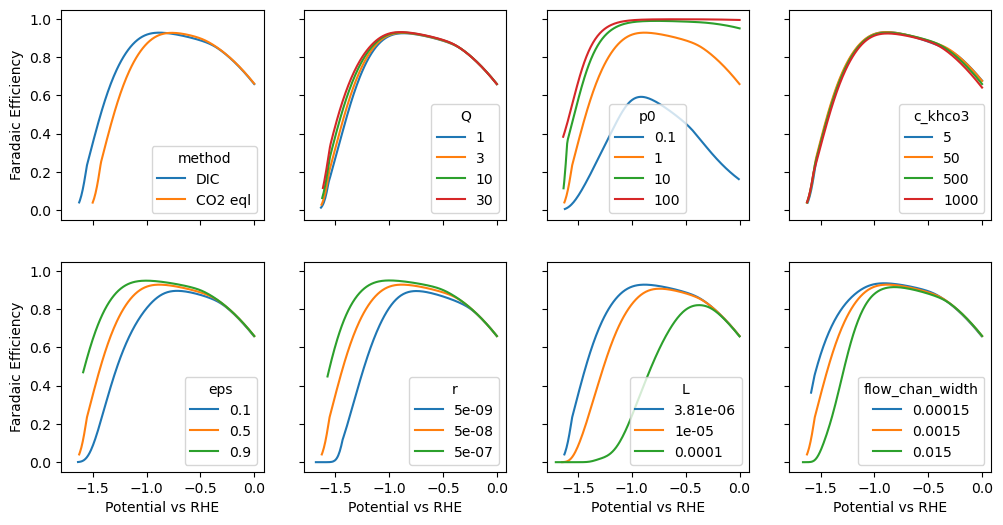

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6), sharex=True, sharey=True)
for i, (name, values) in enumerate(variations.items()):
    args = base_args.copy()
    for val in values:
        args[name] = val
        if name=='c_khco3': args['c_k'] = val
        ipt = InputParameters(**args)
        S = System(ipt)
        results = solve(S, np.linspace(0.0, -1.2, 241))
        ax[i//4, i%4].plot(results['potential_vs_rhe'], results['fe'], label=val)
    ax[i//4, i%4].legend(title=name)
ax[0,0].set_ylabel('Faradaic Efficiency')
ax[1,0].set_ylabel('Faradaic Efficiency')
for i in range(4):
    ax[1,i].set_xlabel('Potential vs RHE')
plt.show()

Text(0, 0.5, 'Current Density [mA/cm^2]')

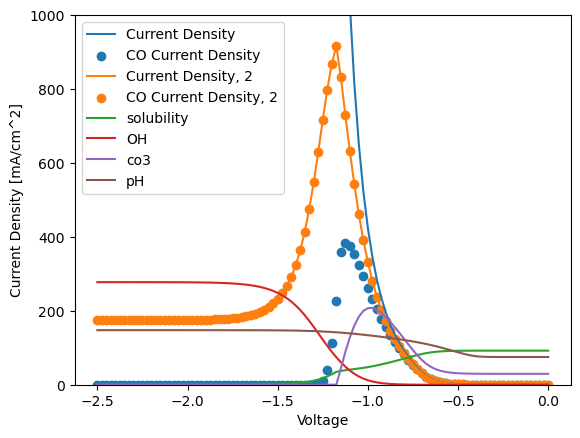

In [11]:
ipt = InputParameters(**base_args)
S = System(ipt)
results = solve(S, np.linspace(0.0, -2.5, 101))
plt.plot(results['phi_ext'], results['current_density'], label='Current Density')
plt.scatter(results['phi_ext'], results['co_current_density'], label='CO Current Density')

ipt = InputParameters(**base_args)
S = System(ipt)
S.electrode_reaction_kinetics['b_H2b'] *= 10
# S.electrode_reaction_kinetics['E_0_CO2'] = -1.11
results = solve(S, np.linspace(0.0, -2.5, 101))
plt.plot(results['phi_ext'], results['current_density'], label='Current Density, 2')
plt.scatter(results['phi_ext'], results['co_current_density'], label='CO Current Density, 2')
plt.plot(results['phi_ext'], results['solubility']*100, label='solubility')
plt.plot(results['phi_ext'], results['c12']/100, label='OH')
plt.plot(results['phi_ext'], results['co3']/10, label='co3')
plt.plot(results['phi_ext'], results['pH']*10, label='pH')

plt.ylim(0, 1000)
plt.legend()
plt.xlabel('Voltage')
plt.ylabel('Current Density [mA/cm^2]')

Why does CO current density drop so massively beyond -1.2V?

Test the new solve_current method

In [12]:
solve_current(S, 2000)

{'phi_ext': -1.1713721581642118,
 'k0': 57357.082186012565,
 'eff_0': 0.019495427283756087,
 'c00': 0.6640344793669124,
 'r_H2': 0.01861761950490266,
 'c10': 14327.118243790095,
 'k1': 73331.81902783852,
 'eff_1': 0.016558920110338354,
 'c01': 0.5640139984779209,
 'c11': 12688.394963000133,
 'A_1': -21733.97654208327,
 'B_2': 4904.8320001877655,
 'c20': -4047.3203976537116,
 'c02': 0.28444825209628033,
 'c12': 7233.064604839794,
 'k2': 65421.94922040893,
 'eff_2': 0.017870975688363804,
 'c03': 0.21841715896975863,
 'c21': 0.0,
 'A_1_1': -12263.001188404887,
 'B_2_1': 11467.238507078751,
 'potential_vs_rhe': -1.5674027687990701,
 'co_current_density': 921.0613879521203,
 'current_density': 921.0620723504281,
 'co2': 0.21841715896975863,
 'co3': 0.0,
 'pH': 14.171379434653252,
 'fe': 0.9999992569465964,
 'parasitic': 0.006711335364913746,
 'electrode': 0.04773080727326114,
 'gdl_flux': 0.05444214263817489,
 've_rhe': 0.3228465718626837,
 'hco3': 0.0,
 'ee': 0.3228463319704396,
 've_she':

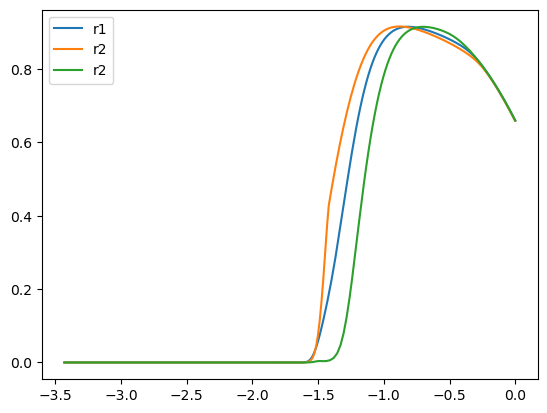

In [13]:
ipt = InputParameters(**args)
S = System(ipt)
S.chemical_reaction_rates['k1f'] = 2.3
results = solve(S, np.linspace(0.0, -2.5, 241))
plt.plot(results['potential_vs_rhe'], results['fe'], label='r1')

ipt = InputParameters(**args)
S = System(ipt)
S.chemical_reaction_rates['k1f'] = 0.2
results = solve(S, np.linspace(0.0, -2.5, 241))
plt.plot(results['potential_vs_rhe'], results['fe'], label='r2')

ipt = InputParameters(**args)
S = System(ipt)
S.chemical_reaction_rates['k1f'] = 200
results = solve(S, np.linspace(0.0, -2.5, 241))
plt.plot(results['potential_vs_rhe'], results['fe'], label='r2')

plt.legend()

196302932.56581745
515230794.1360038
5152307941.360038


Text(0, 0.5, 'Faradaic Efficiency')

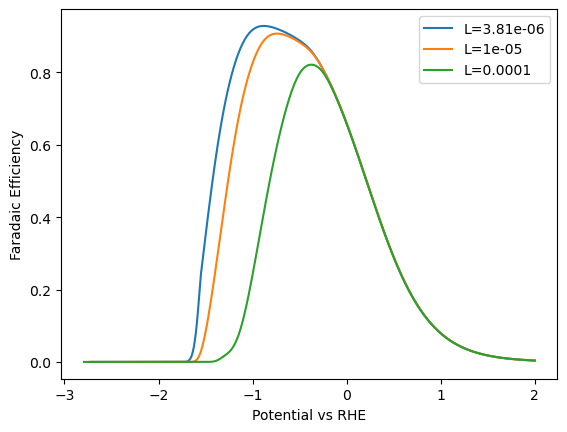

In [14]:
V = np.linspace(-2,2,500)

ipt = InputParameters(**base_args)
S = System(ipt)
results = solve(S, V)
plt.plot(results['potential_vs_rhe'], results['fe'], label=f'L={base_args["L"]}')
print(results['current_density'].max())

for L in [1e-5, 1e-4]:
    args = base_args.copy()
    args['L'] = L
    ipt = InputParameters(**args)
    S = System(ipt)
    results = solve(S, V)
    plt.plot(results['potential_vs_rhe'], results['fe'], label=f'L={L}')
    print(results['current_density'].max())

plt.legend()
plt.xlabel('Potential vs RHE')
plt.ylabel('Faradaic Efficiency')

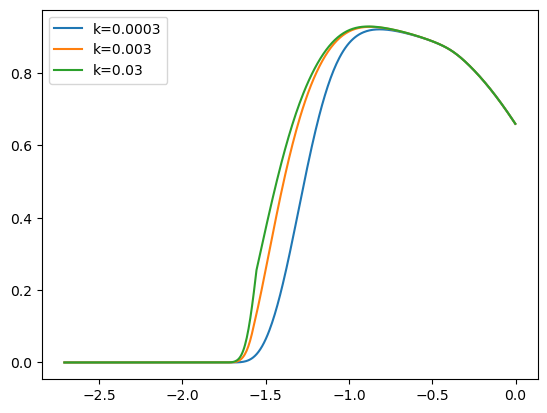

In [15]:
V = np.linspace(-2,0,500)

for k in [3e-4, 3e-3, 3e-2]:
    args = base_args.copy()
    ipt = InputParameters(**args)
    S = System(ipt)
    S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient'] = k
    results = solve(S, V)
    plt.plot(results['potential_vs_rhe'], results['fe'], label=f'k={k}')

plt.legend()